In [7]:
!ls ./data_video_3

00305.MTS  00306.MTS


In [1]:
%matplotlib inline
%load_ext autoreload
# use %autoreload command to reload all libraries

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import argparse
import datetime
import imutils
import time



In [ ]:
cap = cv2.VideoCapture('data_video_1/Ёлочная 2017-1080.mp4')
eps = 0.9
min_area = 20
prev_ret, prev_frame = cap.read()
prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

prev_frame_small = imutils.resize(prev_frame, width=400)
prev_frame_small = cv2.GaussianBlur(prev_frame_small, (21, 21), 0)
sc = prev_frame.shape[1]/400

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_small = imutils.resize(frame, width=400)
    frame_small = cv2.GaussianBlur(frame_small, (21, 21), 0)
    frameDelta = cv2.absdiff(prev_frame_small, frame_small)
    thresh = cv2.threshold(frameDelta, 15, 125, cv2.THRESH_BINARY)[1]
    
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    for c in cnts:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < min_area:
            continue
 
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        x, y, w, h = int(x*sc), int(y*sc), int(w*sc), int(h*sc)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    cv2.imshow('frame',frame)
    prev_frame_small = cv2.addWeighted(prev_frame_small,0.95, frame_small, 0.05,0)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
import numpy as np
import cv2
cap = cv2.VideoCapture('data_video_1/Ёлочная 2017-1080.mp4')
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0,255,(100,3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
if not ret:
    print('ой')
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
while(1):
    ret,frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)
    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
cv2.destroyAllWindows()
cap.release()

error: OpenCV(4.0.0) /io/opencv/modules/video/src/lkpyramid.cpp:1229: error: (-215:Assertion failed) (npoints = prevPtsMat.checkVector(2, CV_32F, true)) >= 0 in function 'calc'


In [2]:
import cv2
import numpy as np
cap = cv2.VideoCapture("data_video_1/Ёлочная 2017-1080.mp4")
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
print(prvs.shape)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
print(hsv.shape)
while(1):
    ret, frame2 = cap.read()
    next_frame = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    #print(next.shape)
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 2)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
    print(mag.shape)
    hsv[...,0] = ang*180/np.pi/2
    #print(mag.shape, ang.shape)
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    #print(hsv.shape)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    #print(bgr.shape)
    cv2.imshow('frame2',bgr)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',bgr)
    prvs = next
cap.release()
cv2.destroyAllWindows()

(1080, 1920)
(1080, 1920, 3)


TypeError: Expected cv::UMat for argument 'next'

In [ ]:
import cv2
import numpy as np
import argparse
import datetime
import imutils
import time

cap = cv2.VideoCapture("/media/user/Новый том/Netology/netology_git/data_diplom/data_obraz_1/obraz1.mp4")
ret, frame1 = cap.read()
min_area = 10
scale_percent=20
sh = frame1.shape
width = int(frame1.shape[1] * scale_percent / 100)
height = int(frame1.shape[0] * scale_percent / 100)

prvs3 = cv2.resize(frame1, (width, height))
prvs = cv2.cvtColor(prvs3,cv2.COLOR_BGR2GRAY)
prvs = cv2.medianBlur(prvs, 5)
prvs = cv2.GaussianBlur(prvs, (9, 9), 0)
flow = np.zeros([7, prvs.shape[0], prvs.shape[1], 2])
kernel = np.array([[-1,-2,-1],[-2,22,-2],[-1,-2,-1]])/10
i_frame = 0
hsv = np.zeros_like(prvs3)
hsv[...,1] = 255
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
while(1):
    ret, frame2 = cap.read()
    if not ret:
        break
    img_yuv = cv2.cvtColor(frame2, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    
    frame2 = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    next_fr3 = cv2.resize(frame2, (width, height))
    
    
    #frame2 = cv2.filter2D(frame2,-1 , kernel)
    next_fr = cv2.cvtColor(next_fr3,cv2.COLOR_BGR2GRAY)
    next_fr = cv2.resize(img_yuv[:,:,0], (width, height))
    next_fr = cv2.medianBlur(next_fr, 5)
    next_fr = cv2.GaussianBlur(next_fr, (9, 9), 0)
    
    
        
    flow[i_frame] = cv2.calcOpticalFlowFarneback(prvs,next_fr, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    flow_tmp = np.mean(flow, axis=0)
    print(prvs[100,100])
    print(flow[i_frame,100,100])
    mag, ang = cv2.cartToPolar(flow_tmp[...,0], flow_tmp[...,1])
    #print(mag)
    i_frame = (i_frame+1)%7
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = mag*255
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    bgr = cv2.resize(bgr, (sh[1],sh[0]))
    prev_frame_small = cv2.addWeighted(frame2,0.5,bgr , 0.5,0)
    
    frameDelta = cv2.absdiff(prvs, next_fr)
    thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    for c in cnts:
        if cv2.contourArea(c) < min_area:
            continue
        (x, y, w, h) = cv2.boundingRect(c)
        x, y, w, h = int(x*width), int(y*height), int(w*width), int(h*height)
        cv2.rectangle(prev_frame_small, (x, y), (x + w, y + h), (255, 255, 255), 2)
    
    cv2.imshow('frame2',prev_frame_small)
    k = cv2.waitKey(1) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',next_fr)
        cv2.imwrite('opticalhsv.png',bgr)
    prvs = next_fr
cap.release()
cv2.destroyAllWindows()

62
[-0.28128394 -0.62234646]
84
[-0.00455554  0.01311348]
83
[0.07604666 0.07317881]
83
[-0.07693265 -0.13274804]
84
[-0.0076405  -0.01376472]
84
[0.01076504 0.04194314]
84
[-0.05439731 -0.11753067]
84
[0.02575358 0.02011961]
84
[-0.00267193  0.02057193]
84
[0.00814192 0.01060225]
84
[-0.01697051 -0.02169467]
84
[0.02259609 0.01593698]
84
[-2.18630561e-07  2.96217699e-08]
84
[-0.00681337  0.0003803 ]
84
[0.0176607  0.01148448]
84
[ 0.02060039 -0.00300359]
84
[0.0228282  0.06826862]
84
[-0.04702802 -0.06913592]
84
[0.01161935 0.06198234]
84
[-0.05666939 -0.06024642]
84
[0.01216483 0.00536082]
85
[0.16826844 0.23090762]
85
[-0.00769266 -0.03291531]
86
[0.09419986 0.12465476]
87
[-0.02937455 -0.01981986]
87
[-0.0047866   0.07833604]
87
[-0.04844204 -0.0492308 ]
86
[0.08320258 0.08415902]
87
[-0.00301049  0.00026959]
86
[0.06016261 0.02627791]
87
[0.00844076 0.03639361]
87
[ 0.00365772 -0.21901789]
87
[-2.23320242e-07 -1.42969469e-07]
87
[0.09965844 0.07628031]
86
[-0.02790998 -0.0187777 ]

84
[0.03188644 0.00249599]
85
[ 0.00310953 -0.00727313]
85
[-0.08447822 -0.21573117]
84
[4.61067629e-07 2.09259952e-07]
84
[ 0.05039183 -0.01310935]
85
[0.00655059 0.00665081]
85
[0.00708608 0.01740097]
85
[-0.00304638  0.00610204]
85
[-0.00134908 -0.00471971]
85
[-0.01275356 -0.00352674]
85
[0.01822121 0.01595893]
85
[ 0.0148289  -0.03969805]
85
[0.02580277 0.01145971]
85
[-0.00877105 -0.01937421]
85
[-0.05578059  0.01713714]
84
[0.00573894 0.01698876]
84
[0.00232633 0.01369817]
84
[0.01233961 0.06672028]
84
[0.02806087 0.02458671]
84
[2.23099028e-06 1.90043932e-06]
84
[-0.024605    0.02193935]
84
[ 0.04363087 -0.0191029 ]
85
[-0.03421632  0.03916816]
85
[0.00152776 0.00570646]
85
[-0.00180896 -0.01002134]
85
[6.98099800e-09 1.46054717e-07]
85
[0.01608517 0.00455522]
85
[0.00071251 0.00230682]
85
[ 0.00014564 -0.00407074]
85
[4.25303028e-07 6.37258665e-07]
85
[0.02053094 0.01972852]
85
[2.77993195e-07 4.53241171e-07]
85
[-0.0430963  -0.01636076]
85
[-9.48735561e-08  1.86932461e-08]
85

83
[-0.02531019 -0.08927869]
83
[0.03591576 0.00361382]
83
[0.00589223 0.04675459]
83
[-0.02141372 -0.16685298]
83
[-0.006566    0.01509186]
83
[1.96720380e-03 1.75947207e-05]
83
[-0.05067753 -0.06092865]
83
[-0.03420949  0.08895124]
83
[-0.00632923 -0.00580482]
83
[0.23280516 0.31762081]
83
[0.01842479 0.07169729]
83
[-0.02654657 -0.0477337 ]
83
[-0.0228426  -0.05790389]
83
[0.04297273 0.05096148]
83
[-0.00723558 -0.04726078]
83
[-0.00355098  0.00662058]
83
[0.11551005 0.08438058]
84
[-0.00421938 -0.01718041]
84
[-0.02131745 -0.03221128]
84
[ 0.02741474 -0.01253624]
84
[0.00277994 0.00071172]
84
[ 0.00517814 -0.00679579]
85
[0.03062175 0.0471534 ]
86
[-0.00071977 -0.01280679]
86
[5.76663369e-05 6.48457572e-05]
86
[-0.03755717 -0.04574533]
85
[0.00069027 0.00083277]
85
[0.01186935 0.02258101]
86
[0.03683357 0.06010588]
86
[ 0.0205125  -0.00555622]
86
[0.01288835 0.01229812]
86
[-0.01723364 -0.02446633]
86
[0.02489915 0.08413321]
86
[-0.07372617 -0.02116929]
86
[-0.02696774 -0.0130684 ]

84
[-0.0241367   0.02396658]
84
[-0.05167486 -0.0550505 ]
84
[-0.0185606  -0.05532716]
84
[-3.57004355e-05 -7.59488437e-03]
84
[-0.02766633  0.00387073]
84
[-0.02497929  0.00665315]
84
[0.06422396 0.02938276]
84
[-0.02291489 -0.00050966]
84
[0.02425607 0.05284641]
84
[ 0.00386358 -0.0607153 ]
84
[-0.00137987 -0.02288166]
84
[-0.00314957 -0.00274664]
84
[ 0.03335995 -0.00285614]
84
[-0.0222764  -0.01192679]
84
[0.06476249 0.00675447]
84
[-0.03214031 -0.02065424]
84
[ 0.00329496 -0.00782906]
84
[0.00143021 0.01260403]
84
[0.07185312 0.12717746]
84
[0.02196798 0.0921316 ]
84
[-0.01738909 -0.04866988]
84
[-0.01977776 -0.02344128]
84
[-0.02319011 -0.02330435]
84
[0.01766161 0.04520383]
84
[-0.03763114 -0.02452064]
84
[0.14628465 0.01252452]
84
[6.01304673e-05 2.25139538e-05]
84
[-0.00632826 -0.01164718]
84
[-0.00467813  0.00339747]
84
[-0.00080191 -0.0005465 ]
84
[-0.05697845 -0.07229017]
85
[-0.01502043  0.0060076 ]
85
[-0.01561903  0.03905292]
84
[0.00883799 0.01009121]
84
[0.02790543 0.0

86
[ 0.00181926 -0.01616181]
86
[0.03498944 0.09337863]
87
[-0.00990199  0.0347012 ]
86
[-0.01009524 -0.01145762]
86
[0.01108976 0.0172654 ]
86
[ 0.00754829 -0.16851033]
87
[-3.53488133e-07  2.60248498e-07]
87
[-0.00264578  0.01918431]
87
[-0.00240948 -0.03281694]
87
[-0.01963321  0.13713776]
86
[-0.00460754  0.02602234]
87
[-0.01705421 -0.03663466]
86
[-0.0108422   0.00520566]
86
[-0.01486137 -0.11977224]
86
[-0.00857629  0.02531817]
85
[-0.00275284 -0.02744959]
85
[-0.0051595  -0.00330144]
85
[0.01886406 0.04354643]
85
[-0.02627575  0.01348168]
85
[-0.01569554 -0.01297339]
85
[ 0.03713755 -0.05802007]
86
[-0.18517129 -0.1353377 ]
85
[7.07925494e-07 6.64515710e-07]
85
[0.17280281 0.16581661]
85
[-0.00565322 -0.01504135]
85
[-0.00731233  0.0217112 ]
85
[0.01797595 0.00530931]
85
[-0.06931087 -0.03453507]
85
[-0.01327897 -0.00223876]
85
[ 0.02294837 -0.00575244]
85
[0.01739104 0.03315529]
85
[ 0.04408439 -0.00394724]
85
[0.02380081 0.03402912]
85
[0.02983158 0.06753203]
85
[1.85016706e-

85
[-0.00940753 -0.0035254 ]
85
[0.05259276 0.06828091]
84
[-0.0080134 -0.0156493]
84
[0.03762545 0.04798174]
84
[-0.04240724 -0.01558073]
84
[-0.01197836  0.04321354]
85
[-1.46177371e-07  3.65252959e-07]
85
[ 0.0067875  -0.01056808]
85
[0.01764153 0.01532307]
85
[-0.02543622 -0.06522034]
85
[-0.00753572 -0.03060524]
84
[ 0.00975969 -0.03500897]
84
[-0.00152159 -0.00121705]
84
[0.00429069 0.04480656]
84
[0.02604471 0.00597703]
84
[-0.03153921 -0.00747441]
84
[-0.01365805  0.00023091]
85
[0.04344388 0.04766181]
85
[0.00919128 0.00668269]
85
[-0.00554018 -0.06227266]
85
[-0.06766745 -0.0510199 ]
85
[-0.02718443 -0.07356238]
85
[-5.88835078e-08  2.65179096e-07]
85
[-0.02579628  0.02375254]
85
[0.00510372 0.0118566 ]
85
[ 0.01251086 -0.01335203]
85
[0.02937498 0.04420973]
85
[-0.03763771 -0.02647402]
85
[ 0.01351016 -0.01246425]
85
[-0.05330943  0.0078955 ]
85
[0.02000587 0.00487384]
85
[-0.01561654 -0.00465551]
85
[-0.00121825 -0.02546181]
85
[-0.00508509  0.01089095]
85
[-0.01946756 -0.0

83
[0.01013037 0.00404205]
83
[-0.01306318  0.04575194]
83
[0.00062598 0.00645422]
83
[0.1254756  0.03537401]
84
[0.07320557 0.07771309]
84
[0.00964673 0.00225109]
84
[-0.00046039 -0.02194918]
84
[0.02030285 0.02828948]
84
[-0.00312032 -0.00778646]
84
[ 0.0237655  -0.08809838]
85
[0.05224925 0.05393168]
85
[-8.51475561e-05 -7.48856182e-05]
85
[-5.10725949e-05 -2.39485053e-05]
85
[0.01164706 0.03168692]
85
[ 1.83755916e-03 -6.87354550e-05]
85
[-4.3508946e-05 -6.8925583e-05]
85
[-1.85974986e-05 -1.59684641e-05]
85
[0.00438047 0.04229678]
85
[-1.56786726e-07 -2.10254484e-07]
85
[-2.35819552e-05 -4.68075232e-05]
85
[-0.31839025 -0.06847728]
83
[-0.06653037 -0.01495448]
83
[0.0245446  0.00683017]
83
[0.02895052 0.00967016]
83
[ 2.46770310e-06 -5.77917854e-06]
83
[-0.01589596 -0.03664054]
84
[0.00338702 0.01157812]
84
[-0.01477967 -0.02524098]
84
[-0.01062294 -0.00411396]
83
[0.055211   0.05101049]
84
[-0.00805342  0.01788424]
84
[-0.01721144 -0.05354711]
84
[-0.00386782 -0.00909006]
84
[0.0

81
[-0.0151171   0.00318199]
81
[ 0.01763486 -0.00083574]
81
[-0.02973924 -0.0204834 ]
81
[0.01410571 0.03395113]
82
[-0.07910725 -0.07057149]
83
[0.01767408 0.06667593]
83
[-0.01218879 -0.00972071]
83
[0.04314107 0.08454426]
83
[0.05251392 0.00331613]
84
[-0.01531739 -0.16369018]
84
[-0.04059806 -0.04282827]
85
[0.01757422 0.06217194]
84
[-0.00796537 -0.02199433]
85
[ 0.02453004 -0.00812489]
84
[-0.00335638  0.00064138]
84
[-0.0067051  -0.02534656]
84
[ 0.03469334 -0.00075288]
84
[0.02374532 0.00770622]
84
[-0.03301679 -0.10370484]
84
[0.00093417 0.01247936]
84
[0.09976685 0.08965372]
85
[-0.01395439 -0.08226766]
86
[-0.04775227 -0.09240325]
86
[-0.02059775  0.01506086]
86
[0.040791   0.05640202]
86
[ 0.09052382 -0.00504868]
86
[-0.02567155  0.00704212]
86
[ 0.00091324 -0.04242959]
86
[ 0.01091979 -0.00826724]
86
[ 0.00977501 -0.01083768]
86
[0.02245622 0.0379982 ]
86
[0.0229613  0.00733936]
86
[-7.19351415e-03  3.16327460e-05]
86
[-0.03228295 -0.00863494]
85
[-0.0085353  -0.00464595]

75
[ 0.00634654 -0.00435752]
75
[-0.06070861 -0.03858566]
75
[0.10527715 0.05068254]
75
[ 0.00115003 -0.00292267]
75
[0.01750528 0.05624782]
75
[-0.0318097  -0.00904579]
75
[-0.10367189 -0.14747351]
75
[0.00795218 0.02094933]
75
[-0.00966745 -0.01595737]
75
[3.91676913e-05 7.60612602e-05]
75
[0.02557555 0.00426176]
76
[0.01043605 0.00063887]
76
[0.03932192 0.04315224]
76
[0.00647871 0.00666234]
76
[ 0.01581989 -0.0225309 ]
76
[-0.00048    -0.00136983]
76
[0.03376592 0.16128321]
76
[-0.00643038  0.11279205]
76
[-0.06493641  0.0427155 ]
77
[0.04266085 0.05615307]
78
[0.01592726 0.03378681]
78
[ 0.00528263 -0.00686361]
78
[0.05572558 0.04356449]
77
[0.00798529 0.00447609]
77
[-0.01341197 -0.06205837]
77
[-0.00482433 -0.0013173 ]
77
[-0.0297646   0.00667367]
77
[-0.01528596 -0.00148252]
77
[-0.08287118 -0.08053321]
77
[-0.0098276   0.03753641]
76
[ 0.10780741 -0.00856274]
78
[0.09209336 0.04324204]
78
[-0.04922546 -0.0822411 ]
78
[-0.00751593  0.05558498]
77
[0.08632369 0.01291021]
79
[-0.

84
[-0.03720462 -0.0735401 ]
84
[-0.02453302 -0.05245288]
84
[-0.05378764 -0.05923257]
84
[-0.00292665  0.0010112 ]
84
[0.03251229 0.03776421]
84
[-0.00025999 -0.00192027]
84
[-0.00592402  0.00397359]
85
[0.0073541  0.00887608]
85
[0.05299431 0.00481286]
85
[-0.00076847 -0.00278052]
85
[ 0.01775906 -0.01189425]
85
[0.00018927 0.0003596 ]
85
[0.0530922  0.08341248]
85
[-0.14610612  0.08819127]
85
[0.04403716 0.0236435 ]
85
[-0.0436543  -0.02497928]
85
[0.08234304 0.08334075]
86
[ 1.72447022e-02 -2.60288289e-05]
86
[0.01243343 0.01796966]
86
[ 0.03706329 -0.01292873]
87
[ 0.02075825 -0.01506044]
86
[ 0.02277434 -0.01044201]
87
[-0.04555535 -0.01719746]


In [15]:
[i%4 for i in range(10)]

[0, 1, 2, 3, 0, 1, 2, 3, 0, 1]

In [5]:
from IPython.core.debugger import set_trace
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [25]:
import sys
import os
sys_paths = ['../'] # Adding yolov3_pytorch to python paths
for p in sys_paths:
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

In [26]:
import time
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from matplotlib import patches, patheffects

In [27]:
torch.cuda.is_available()

True

In [32]:
from yolov3_pytorch.utils import *
from yolov3_pytorch.yolov3 import *
from yolov3_pytorch.yolov3_tiny import *

In [13]:
imgfile = "data_obraz_1/obr2/obr_2_hr_00024.png"

In [14]:
sz = 416
img_org = Image.open(imgfile).convert('RGB')
img_resized = img_org.resize((sz, sz))
img_torch = image2torch(img_resized)
print(img_torch[0,1])

in torch.Size([1, 3, 416, 416])
tensor([[0.3059, 0.3059, 0.2980,  ..., 0.4039, 0.4000, 0.3961],
        [0.2863, 0.3059, 0.3059,  ..., 0.4039, 0.4000, 0.3961],
        [0.3098, 0.3059, 0.2824,  ..., 0.4078, 0.4039, 0.4000],
        ...,
        [0.0667, 0.0667, 0.0706,  ..., 0.0980, 0.1020, 0.0980],
        [0.0745, 0.0667, 0.0745,  ..., 0.1020, 0.1020, 0.0941],
        [0.0745, 0.0667, 0.0745,  ..., 0.0980, 0.0941, 0.0863]])


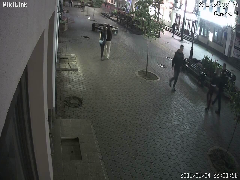

In [48]:
img_org.resize((240,180))

In [49]:
model = Yolov3Tiny(num_classes=80)
model.load_state_dict(torch.load('data/models/yolov3_tiny_coco_01.h5'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [50]:
all_boxes = model.predict_img(img_torch, conf_thresh=0.2)[0]
len(all_boxes)

5

In [51]:
class_names = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

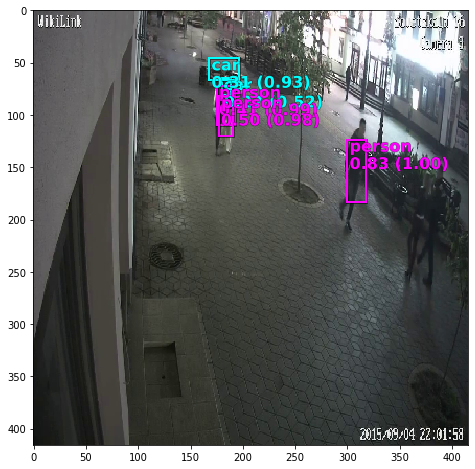

In [52]:
plot_img_detections(img_resized, all_boxes, figsize=(8,8), class_names=class_names)

In [53]:
boxes = nms(all_boxes, 0.4)
len(boxes)

4

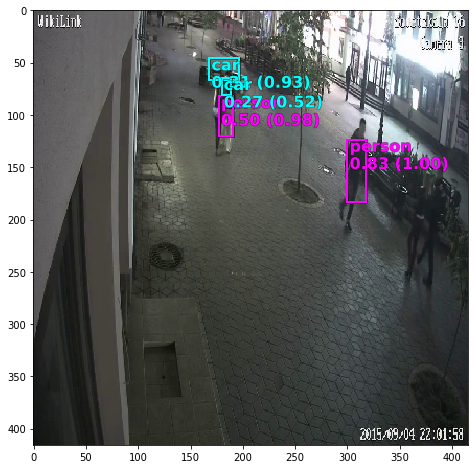

In [54]:
plot_img_detections(img_resized, boxes, figsize=(8,8), class_names=class_names)

In [5]:
model3 = Yolov3(num_classes=80)
model3.load_state_dict(torch.load('data/models/yolov3_coco_01.h5'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [56]:
%%time
all_boxes = model.predict_img(img_torch)[0]

CPU times: user 364 ms, sys: 3.8 ms, total: 368 ms
Wall time: 63.2 ms


In [57]:
all_boxes = model.predict_img(img_torch)[0]
len(all_boxes)

5

In [58]:
boxes = nms(all_boxes, 0.4)
len(boxes)

4

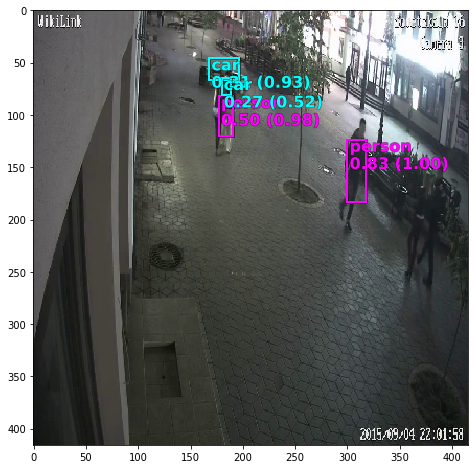

In [59]:
plot_img_detections(img_resized, boxes, figsize=(8,8), class_names=class_names)

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import argparse
import datetime
import imutils
import time

import sys
import os
sys_paths = ['../'] # Adding yolov3_pytorch to python paths
for p in sys_paths:
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

import time
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from matplotlib import patches, patheffects


from yolov3_pytorch.utils import *
from yolov3_pytorch.yolov3 import *
from yolov3_pytorch.yolov3_tiny import *


import multiprocessing as mp


In [13]:



def take_pred(model,queue_in, queue_out):
    #model = model.cuda()
    while True:
        if not queue_in.empty():
             
                data = queue_in.get()
                if type(data) == type('s'):
                    all_boxes = model.predict_img(img_torch, conf_thresh=0.2)[0] 
                    queue_out.put(all_boxes) 
                else:    
                    break  
    

if __name__ == '__main__':    
    try:
        mp.set_start_method('spawn')
    except RuntimeError:
        pass
    #mp.set_start_method('spawn')
    model = Yolov3Tiny(num_classes=80)
    model.load_state_dict(torch.load('data/models/yolov3_tiny_coco_01.h5'))
    model.share_memory()
    #model = model.cuda()
    #model = model3.cuda()
    cap = cv2.VideoCapture('/home/user/netology/netology_git/data_diplom/data_video_1/Шаман 9 марта 2015-1080.mp4')
    ret, frame = cap.read()
    x_sc = frame.shape[1]
    y_sc = frame.shape[0]
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    kernel = np.array([[-1,-2,-1],[-2,22,-2],[-1,-2,-1]])/10
    all_boxes = []
    q_in = mp.Queue() 
    q_out = mp.Queue()
    p1 = mp.Process(target=take_pred, args=(model, q_out, q_in))
    p1.start()    
    i_iter = 0
    status_frame = True
    #torch.cuda.init( )
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break
        sz = 416

        img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])

        frame = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        frame = cv2.filter2D(frame,-1 , kernel)
        img_resized = cv2.resize(frame,(sz,sz))
        img_torch = torch.from_numpy(img_resized/255)
        fr_tmp = img_torch.numpy()
        img_torch = img_torch[np.newaxis, :] 
        img_torch = img_torch.permute(0, 3, 1, 2)
        img_torch = img_torch.type('torch.FloatTensor')
        if i_iter == 0 and status_frame:
            status_frame = False
            q_out.put(img_torch)
        #img_torch = image2torch(img_resized)  

        #img_torch = torch.from_numpy(img_resized/255)
        #fr_tmp = img_torch.numpy()
        #img_torch = img_torch[np.newaxis, :] 
        #img_torch = img_torch.permute(0, 3, 1, 2)
        ##print(img_torch[0,0])
        #img_torch = img_torch.type('torch.cuda.FloatTensor')
        ##print(img_torch[0,0])


        #all_boxes = model.predict_img(img_torch, conf_thresh=0.2)[0]    
        #all_boxes = do_detect2(model, img_torch, conf_thresh=0.2, nms_thresh=0.5, use_cuda=True)
        #print(all_boxes[0])
        #boxes = np.array(nms(all_boxes, 0.4))

        #boxess = boxes[:,0:4]

        #print(boxess[0:4])
        #boxess = boxess * np.array([x_sc,y_sc,x_sc,y_sc])
        #print(boxess[0:4])
        if not q_in.empty():
            print('оп')
            all_boxes = q_in.get()
            status_frame = False
          
        if len(all_boxes) > 0:    
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in nms(all_boxes, 0.5):
                if x1>2 or x2>2 or y1>2 or y2>2 or cls_pred != 0:
                    continue
                #print(bx)
                x, y, w, h = int(x1*x_sc), int(y1*y_sc), int(x2*x_sc), int(y2*y_sc) 
                #print(x1, y1, x2, y2, conf, cls_conf, cls_pred)

                cv2.rectangle(frame, (x-w//2, y-h//2), (x+w//2, y+h//2), (0, 255, 0), 2)

        #cv2.imshow('frame',fr_tmp)
        #fr_tmp2 = img_torch.permute(0, 2, 3, 1).cpu().numpy()[0]
        cv2.imshow('frame',frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    p1.join()        
    cap.release()
    cv2.destroyAllWindows()


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Обрыв канала
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Brok

In [17]:

#
#
#
#
#
#
#
#

def take_pred(queue_in, queue_out):
    print('into')
    while True:
        if not queue_in.empty():
            data = queue_in.get()
            print(type(data))
            queue_out.put([[0.2,0.5,0.4,0.6,1,1,1]]) 
            del data
    #model = Yolov3Tiny(num_classes=80)
    #print(type(model))
    
    #model.load_state_dict(torch.load('data/models/yolov3_tiny_coco_01.h5'))
    #model = model.cuda()
    #print(type(model))      
    #while True:
    #    print('into')
    #    
    #    if not queue_in.empty():
    #        print('queue not empty')
    #        data = queue_in.get()
    #        print(type(data))
    #        if isinstance(data, np.ndarray):
    #            img_torch = torch.from_numpy(data/255)
    #            fr_tmp = img_torch.numpy()
    #            img_torch = img_torch[np.newaxis, :] 
    #            img_torch = img_torch.permute(0, 3, 1, 2)
    #            img_torch = img_torch.type('torch.cuda.FloatTensor')
    #            all_boxes = model.predict_img(img_torch, conf_thresh=0.2)[0] 
    #            
    #            queue_out.put(all_boxes) 
    #        else:
    #            break
    

if __name__ == '__main__':    
    #model = Yolov3Tiny(num_classes=80)
    #model.load_state_dict(torch.load('data/models/yolov3_tiny_coco_01.h5'))
    #model = model3.cuda()
    try:
        mp.set_start_method('spawn')
    except RuntimeError:
        pass
    cap = cv2.VideoCapture('/home/user/netology/netology_git/data_diplom/data_video_1/Шаман 9 марта 2015-1080.mp4')
    ret, frame = cap.read()
    x_sc = frame.shape[1]
    y_sc = frame.shape[0]
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    kernel = np.array([[-1,-2,-1],[-2,22,-2],[-1,-2,-1]])/10
    all_boxes = []
    q_in = mp.Queue() 
    q_out = mp.Queue()
    #p1 = torch.multiprocessing.spawn( take_pred , args = (q_out, q_in) , nprocs = 1 , join = True , daemon = False )
    p1 = mp.Process(target=take_pred, args=( q_out, q_in))
    p1.start()    
    i_iter = 0
    status_frame = True
    #torch.cuda.init( )
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break
        sz = 416

        img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])

        frame = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        frame = cv2.filter2D(frame,-1 , kernel)
        img_resized = cv2.resize(frame,(sz,sz))
        if i_iter == 0:
            print('in')
            status_frame = False
            q_out.put(img_resized)
            
        i_iter =  (i_iter +1)%30   
        #img_torch = image2torch(img_resized)  

        #img_torch = torch.from_numpy(img_resized/255)
        #fr_tmp = img_torch.numpy()
        #img_torch = img_torch[np.newaxis, :] 
        #img_torch = img_torch.permute(0, 3, 1, 2)
        ##print(img_torch[0,0])
        #img_torch = img_torch.type('torch.cuda.FloatTensor')
        ##print(img_torch[0,0])


        #all_boxes = model.predict_img(img_torch, conf_thresh=0.2)[0]    
        #all_boxes = do_detect2(model, img_torch, conf_thresh=0.2, nms_thresh=0.5, use_cuda=True)
        #print(all_boxes[0])
        #boxes = np.array(nms(all_boxes, 0.4))

        #boxess = boxes[:,0:4]

        #print(boxess[0:4])
        #boxess = boxess * np.array([x_sc,y_sc,x_sc,y_sc])
        #print(boxess[0:4])
        print( q_in.empty())
        if not q_in.empty():
            all_boxes = q_in.get()
            status_frame = False
            print('out')
        print(len(all_boxes), i_iter)    
        if len(all_boxes) > 0:    
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in nms(all_boxes, 0.5):
                if x1>2 or x2>2 or y1>2 or y2>2 or cls_pred != 0:
                    continue
                #print(bx)
                x, y, w, h = int(x1*x_sc), int(y1*y_sc), int(x2*x_sc), int(y2*y_sc) 
                #print(x1, y1, x2, y2, conf, cls_conf, cls_pred)

                cv2.rectangle(frame, (x-w//2, y-h//2), (x+w//2, y+h//2), (0, 255, 0), 2)

        #cv2.imshow('frame',fr_tmp)
        #fr_tmp2 = img_torch.permute(0, 2, 3, 1).cpu().numpy()[0]
        cv2.imshow('frame',frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            q_out.put('q')
            break
    p1.join()        
    cap.release()
    cv2.destroyAllWindows()


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Обрыв канала
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Brok

in
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [48]:
import pycuda


ModuleNotFoundError: No module named 'pycuda'

TypeError: 'numpy.ndarray' object is not callable

In [34]:
cv2.resize?

In [8]:
cv2.threshold?

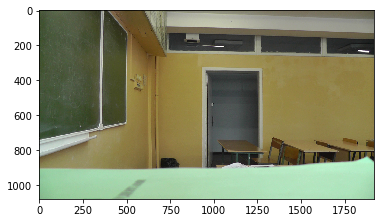

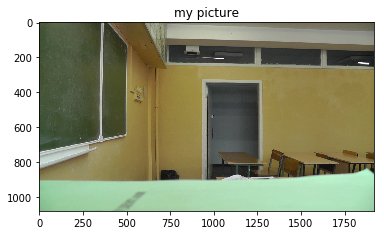

In [6]:
cap = cv2.VideoCapture('data_video_3/00306.MTS')
cap.set(cv2.CAP_PROP_POS_MSEC,5000)      # Go to the 1 sec. position
ret,frame = cap.read()                   # Retrieves the frame at the specified second
#cv2.imwrite("image.jpg", frame)
RGB_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Saves the frame as an image
#cv2.imshow("Frame Name",frame)           # Displays the frame on screen
#cv2.waitKey() 
plt.imshow(RGB_im)
plt.show()
ret2,frame2 = cap.read()  
RGB_im2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
cap.release()
cv2.destroyAllWindows()

plt.imshow(RGB_im2)


plt.title('my picture')
plt.show()

In [10]:
import PIL

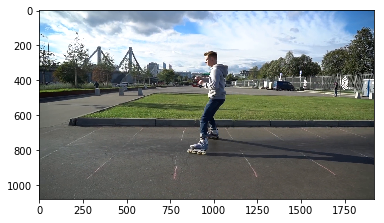

In [12]:
im = np.array(PIL.Image.open('./data_video_1/roller1/roller1_hr_00001.png'))
plt.imshow(im.resize())
plt.show()

In [ ]:
#!/usr/bin/python
# The contents of this file are in the public domain. See LICENSE_FOR_EXAMPLE_PROGRAMS.txt
#
# This example shows how to use the correlation_tracker from the dlib Python
# library.  This object lets you track the position of an object as it moves
# from frame to frame in a video sequence.  To use it, you give the
# correlation_tracker the bounding box of the object you want to track in the
# current video frame.  Then it will identify the location of the object in
# subsequent frames.
#
# In this particular example, we are going to run on the
# video sequence that comes with dlib, which can be found in the
# examples/video_frames folder.  This video shows a juice box sitting on a table
# and someone is waving the camera around.  The task is to track the position of
# the juice box as the camera moves around.
#
#
# COMPILING/INSTALLING THE DLIB PYTHON INTERFACE
#   You can install dlib using the command:
#       pip install dlib
#
#   Alternatively, if you want to compile dlib yourself then go into the dlib
#   root folder and run:
#       python setup.py install
#
#   Compiling dlib should work on any operating system so long as you have
#   CMake installed.  On Ubuntu, this can be done easily by running the
#   command:
#       sudo apt-get install cmake
#
#   Also note that this example requires Numpy which can be installed
#   via the command:
#       pip install numpy

import os
import glob

import dlib

# Path to the video frames
video_folder = os.path.join("..", "examples", "video_frames")

# Create the correlation tracker - the object needs to be initialized
# before it can be used
tracker = dlib.correlation_tracker()

win = dlib.image_window()
# We will track the frames as we load them off of disk
for k, f in enumerate(sorted(glob.glob(os.path.join(video_folder, "*.jpg")))):
    print("Processing Frame {}".format(k))
    img = dlib.load_rgb_image(f)

    # We need to initialize the tracker on the first frame
    if k == 0:
        # Start a track on the juice box. If you look at the first frame you
        # will see that the juice box is contained within the bounding
        # box (74, 67, 112, 153).
        tracker.start_track(img, dlib.rectangle(74, 67, 112, 153))
    else:
        # Else we just attempt to track from the previous frame
        tracker.update(img)

    win.clear_overlay()
    win.set_image(img)
    win.add_overlay(tracker.get_position())
    dlib.hit_enter_to_continue()

In [19]:
import os
import glob
import numpy as np
import cv2
import dlib

# Path to the video frames
video_folder = os.path.join("..", "examples", "video_frames")

# Create the correlation tracker - the object needs to be initialized
# before it can be used
tracker = dlib.correlation_tracker()

win = dlib.image_window()


cap = cv2.VideoCapture('/home/user/netology/netology_git/data_diplom/data_obraz_1/obraz1.mp4')
eps = 0.9
min_area = 20
prev_ret, prev_frame = cap.read()
prev_frame = cv2.cvtColor(prev_frame,cv2.COLOR_BGR2GRAY)
tracker.start_track(prev_frame, dlib.rectangle(990, 110, 1010, 190))
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)    
    #img = dlib.load_rgb_image(frame)    
    
    tracker.update(frame)
    win.clear_overlay()
    win.set_image(frame)
    print(tracker.get_position())
    win.add_overlay(tracker.get_position())
    cv2.waitKey(20) 
    dlib.hit_enter_to_continue()    

In [30]:
model = Yolov3Tiny(num_classes=80)
model.load_state_dict(torch.load('data/models/yolov3_tiny_coco_01.h5'))
model = model3.cuda()
cap = cv2.VideoCapture('/home/user/netology/netology_git/data_diplom/data_obraz_1/obraz1.mp4')
kernel = np.array([[-1,-2,-1],[-2,22,-2],[-1,-2,-1]])/10
ret, frame = cap.read()
x_sc = frame.shape[1]
y_sc = frame.shape[0]
#torch.cuda.init( )
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    sz = 416
    frame2 = cv2.filter2D(frame2,-1 , kernel)
    img_resized = cv2.resize(frame,(sz,sz))
    #img_torch = image2torch(img_resized)  
    
    img_torch = torch.from_numpy(img_resized/255)
    fr_tmp = img_torch.numpy()
    img_torch = img_torch[np.newaxis, :] 
    img_torch = img_torch.permute(0, 3, 1, 2)
    #print(img_torch[0,0])
    img_torch = img_torch.type('torch.cuda.FloatTensor')
    #print(img_torch[0,0])
   
    
    all_boxes = model.predict_img(img_torch, conf_thresh=0.2)[0]    
    #all_boxes = do_detect2(model, img_torch, conf_thresh=0.2, nms_thresh=0.5, use_cuda=True)
    #print(all_boxes[0])
    #boxes = np.array(nms(all_boxes, 0.4))
    
    #boxess = boxes[:,0:4]
    
    #print(boxess[0:4])
    #boxess = boxess * np.array([x_sc,y_sc,x_sc,y_sc])
    #print(boxess[0:4])
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in nms(all_boxes, 0.5):
        if x1>2 or x2>2 or y1>2 or y2>2 or cls_pred != 0:
            continue
        #print(bx)
        x, y, w, h = int(x1*x_sc), int(y1*y_sc), int(x2*x_sc), int(y2*y_sc) 
        #print(x1, y1, x2, y2, conf, cls_conf, cls_pred)
        
        cv2.rectangle(frame, (x-w//2, y-h//2), (x+w//2, y+h//2), (0, 255, 0), 2)
    
    #cv2.imshow('frame',fr_tmp)
    #fr_tmp2 = img_torch.permute(0, 2, 3, 1).cpu().numpy()[0]
    cv2.imshow('frame',frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


NameError: name 'frame2' is not defined

In [20]:
i = 0
b = True
if (i == 0) and b:
    print('x')

x


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import argparse
import datetime
import imutils
import time

import sys
import os
sys_paths = ['../'] # Adding yolov3_pytorch to python paths
for p in sys_paths:
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

import time
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from matplotlib import patches, patheffects


from yolov3_pytorch.utils import *
from yolov3_pytorch.yolov3 import *
from yolov3_pytorch.yolov3_tiny import *


import multiprocessing as mp

def take_pred(queue_in, queue_out):
    print('into')
    n = 0
    while True:
        #print('n', n)
        #print(queue_in.empty())
        if not queue_in.empty():
            n+=1
            data = queue_in.get()
            if type(data) == type('s'):
                print(data)
                print('output')
                break   
            print(type(data))
            #time.sleep(1)
            model = Yolov3Tiny(num_classes=80)
            model.load_state_dict(torch.load('data/models/yolov3_tiny_coco_01.h5'))
            model = model.cuda()
            img_torch = torch.from_numpy(data/255)
            img_torch = img_torch[np.newaxis, :] 
            img_torch = img_torch.permute(0, 3, 1, 2)
            print(type(model))
            #img_torch = img_torch.type('torch.FloatTensor') 
            img_torch = img_torch.type('torch.cuda.FloatTensor')
            all_boxes = model.predict_img(img_torch, conf_thresh=0.2)[0] 
            #all_boxes.append([0.5,0.2,0.5,0.2,1,1,0])
            print(type(all_boxes))
            print(len(all_boxes))
            print('2n', n)
            queue_out.put(all_boxes) 
            
            
  
   
    
    #
    #model = model.cuda()
    #print(type(model))      
    #while True:
    #    print('into')
    #    
    #    if not queue_in.empty():
    #        print('queue not empty')
    #        data = queue_in.get()
    #        print(type(data))
    #        if isinstance(data, np.ndarray):
    #            img_torch = torch.from_numpy(data/255)
    #            fr_tmp = img_torch.numpy()
    #            img_torch = img_torch[np.newaxis, :] 
    #            img_torch = img_torch.permute(0, 3, 1, 2)
    #            img_torch = img_torch.type('torch.cuda.FloatTensor')
    #            all_boxes = model.predict_img(img_torch, conf_thresh=0.2)[0] 
    #            
    #            queue_out.put(all_boxes) 
    #        else:
    #            break
    

if __name__ == '__main__':    
    #model = Yolov3Tiny(num_classes=80)
    #model.load_state_dict(torch.load('data/models/yolov3_tiny_coco_01.h5'))
    #model = model3.cuda()
    try:
        mp.set_start_method('spawn')
    except RuntimeError:
        pass
    cap = cv2.VideoCapture('/home/user/netology/netology_git/data_diplom/data_video_1/Шаман 9 марта 2015-1080.mp4')
    #cv2.VideoCapture.set( cv2.CV_CAP_PROP_FPS, 30 ) 
    ret, frame = cap.read()
    x_sc = frame.shape[1]
    y_sc = frame.shape[0]
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    kernel = np.array([[-1,-2,-1],[-2,22,-2],[-1,-2,-1]])/10
    all_boxes = []
    q_in = mp.Queue() 
    q_out = mp.Queue()
    #p1 = torch.multiprocessing.spawn( take_pred , args = (q_out, q_in) , nprocs = 1 , join = True , daemon = False )
    p1 = mp.Process(target=take_pred, args=( q_out, q_in))
    p1.start()    
    i_iter = 0
    status_frame = True
    #torch.cuda.init( )
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break
        sz = 416

        img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])

        frame = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        frame = cv2.filter2D(frame,-1 , kernel)
        img_resized = cv2.resize(frame,(sz,sz))
        if (i_iter == 0) and status_frame:
            print('in')
            #status_frame = False
            q_out.put(img_resized)
            
        i_iter =  (i_iter +1)%15   
        print(i_iter)
        #img_torch = image2torch(img_resized)  

        #img_torch = torch.from_numpy(img_resized/255)
        #fr_tmp = img_torch.numpy()
        #img_torch = img_torch[np.newaxis, :] 
        #img_torch = img_torch.permute(0, 3, 1, 2)
        ##print(img_torch[0,0])
        #img_torch = img_torch.type('torch.cuda.FloatTensor')
        ##print(img_torch[0,0])


        #all_boxes = model.predict_img(img_torch, conf_thresh=0.2)[0]    
        #all_boxes = do_detect2(model, img_torch, conf_thresh=0.2, nms_thresh=0.5, use_cuda=True)
        #print(all_boxes[0])
        #boxes = np.array(nms(all_boxes, 0.4))

        #boxess = boxes[:,0:4]

        #print(boxess[0:4])
        #boxess = boxess * np.array([x_sc,y_sc,x_sc,y_sc])
        #print(boxess[0:4])
        #print('in',q_in.empty())
        if not q_in.empty():
            all_boxes = q_in.get()
            status_frame = True
            print('out')
        #print(len(all_boxes))    
        if len(all_boxes) > 0:    
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in nms(all_boxes, 0.5):
                if x1>2 or x2>2 or y1>2 or y2>2 or cls_pred != 0:
                    continue
                #print(bx)
                x, y, w, h = int(x1*x_sc), int(y1*y_sc), int(x2*x_sc), int(y2*y_sc) 
                print(x1, y1, x2, y2, conf, cls_conf, cls_pred)

                cv2.rectangle(frame, (x-w//2, y-h//2), (x+w//2, y+h//2), (0, 255, 0), 2)

        #cv2.imshow('frame',fr_tmp)
        #fr_tmp2 = img_torch.permute(0, 2, 3, 1).cpu().numpy()[0]
        cv2.imshow('frame',frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            q_out.put('q')
            break
    p1.join()        
    cap.release()
    cv2.destroyAllWindows()

In [1]:
d = {1:'a',2:'b', 3:'c'}

In [2]:
d

{1: 'a', 2: 'b', 3: 'c'}

In [3]:
del d[1]

In [4]:
d

{2: 'b', 3: 'c'}

In [1]:
import multiprocessing as mp

In [2]:
x = [1,2,3,4,5,6,7,8,9]
y = [.9,.8,.7,.6,.5,.4,.3,.2,.1]

def ff(x,y):
    return x*y

pool = mp.Pool(processes=4)
results = pool.apply(ff, args=(x,y))
results

TypeError: can't multiply sequence by non-int of type 'list'

In [17]:
import numpy as np
x  = np.array([3,4,5,6],[5,6,7,8])
x1 = np.array([30,40,50,60])
x2 = np.array([300,400,500,600])
x3 = np.array([6,8,10,12])
x4 = np.array([3,4,5,6])

def f(x1,x2):
    print('d',np.dot(x1.T,x2))
    return np.dot(x1.T,x2)/(np.sqrt(np.sum(x1*x1))*np.sqrt(np.sum(x2*x2)))

print(f(x,x1))
print(f(x,x2))
print(f(x,x3))
print(f(x1,x2))
print(f(x1,x3))
print(f(x2,x3))
print(f(x4,x))


d 860
1.0
d 8600
1.0
d 172
1.0
d 86000
1.0
d 1720
1.0
d 17200
1.0
d 86
1.0


In [45]:
import numpy as np
x  = np.array([[31,4,5,6],[52,6,7,8],[33,4,5,6],[34,4,5,6],[55,6,7,8],[36,4,5,6],[37,4,5,6],[85,6,7,8],[39,4,5,6],[30,4,5,6],[5,61,7,8],[3,42,5,6],[3,34,5,6],[5,46,7,8],[3,54,5,6]])
for i in x:
    print(i)

[31  4  5  6]
[52  6  7  8]
[33  4  5  6]
[34  4  5  6]
[55  6  7  8]
[36  4  5  6]
[37  4  5  6]
[85  6  7  8]
[39  4  5  6]
[30  4  5  6]
[ 5 61  7  8]
[ 3 42  5  6]
[ 3 34  5  6]
[ 5 46  7  8]
[ 3 54  5  6]


In [40]:
x[x[:,2]>4]

array([[3, 4, 5, 6],
       [5, 6, 7, 8],
       [3, 4, 5, 6],
       [3, 4, 5, 6],
       [5, 6, 7, 8],
       [3, 4, 5, 6],
       [3, 4, 5, 6],
       [5, 6, 7, 8],
       [3, 4, 5, 6],
       [3, 4, 5, 6],
       [5, 6, 7, 8],
       [3, 4, 5, 6],
       [3, 4, 5, 6],
       [5, 6, 7, 8],
       [3, 4, 5, 6]])

In [31]:
x[:,2] = x[:,2]+x[:,2]

In [42]:
x

array([[3, 4, 5, 6],
       [5, 6, 7, 8],
       [3, 4, 5, 6],
       [3, 4, 5, 6],
       [5, 6, 7, 8],
       [3, 4, 5, 6],
       [3, 4, 5, 6],
       [5, 6, 7, 8],
       [3, 4, 5, 6],
       [3, 4, 5, 6],
       [5, 6, 7, 8],
       [3, 4, 5, 6],
       [3, 4, 5, 6],
       [5, 6, 7, 8],
       [3, 4, 5, 6]])

In [61]:
from scipy import spatial

s = spatial.KDTree(x)

a = s.query([5,6,5,8], k=5, distance_upper_bound=27)

In [62]:
a


(array([25.15949125, 26.15339366,         inf,         inf,         inf]),
 array([ 9,  0, 15, 15, 15]))

In [63]:
a[0][1] < 654654654654654654654

True

In [64]:
a[0][a[0]<260]

array([25.15949125, 26.15339366])

In [69]:
a_l = a[0][a[0] < 27]
a_n = a[1][:len(a_l)]

In [70]:
a_l

array([25.15949125, 26.15339366])

In [71]:
a_n

array([9, 0])

In [77]:
x = np.vstack((x, np.array([5,5,5,5])))

In [78]:
x

array([[31,  4,  5,  6],
       [52,  6,  7,  8],
       [33,  4,  5,  6],
       [34,  4,  5,  6],
       [55,  6,  7,  8],
       [36,  4,  5,  6],
       [37,  4,  5,  6],
       [85,  6,  7,  8],
       [39,  4,  5,  6],
       [30,  4,  5,  6],
       [ 5, 61,  7,  8],
       [ 3, 42,  5,  6],
       [ 3, 34,  5,  6],
       [ 5, 46,  7,  8],
       [ 3, 54,  5,  6],
       [ 5,  5,  5,  5],
       [ 5,  5,  5,  5]])

In [81]:
nan + 1

NameError: name 'nan' is not defined

In [84]:
x = np.expand_dims(x, axis=0)


In [85]:
x.shape

(1, 17, 4)

In [ ]:
np.transpose(